# ChromProcess Introduction Part 2

In ChromProcess Introduction Part 1, peak collections were created from chromatogram files. In Part 2, these peak tables are used to compile series data (e.g. changes in compound concentrations or peak integrals over time).

Note that the results of each operation should be inspected or validated in some way before they are used to evaluate the 'final' data. The software may not be picking up important features of the data. Tuning the analysis parameters shown in this notebook may remedy issues, or further code must be included to achieve satisfactory results. It is up to the reader to choose a sufficient methods for validation and inspection of the results.

In [1]:
import os
from ChromProcess import Classes

Peak collections can be loaded into objects.

In [2]:
from ChromProcess.Loading import peak_collection_from_csv

peak_collection_directory = 'Sample_analysis/Example/ExperimentalData/ExamplePeakCollections'

peak_tables = []
for file in os.listdir(peak_collection_directory):
    if file.endswith('.csv'):
        peak_tables.append(peak_collection_from_csv(f'{peak_collection_directory}/{file}'))

The experiment conditions go hand-in-hand with the data, so they are loaded into an object. As well as an object containing calibration information for the instrument.

In [3]:
from ChromProcess.Loading import analysis_from_toml
from ChromProcess.Loading import conditions_from_toml

conditions_file = 'Sample_analysis/Example/ExperimentalData/example_conditions.toml'
analysis_file = 'Sample_analysis/Example/Analysis/example_analysis_details.toml'
conditions = conditions_from_toml(conditions_file)
analysis = analysis_from_toml(analysis_file)

The peak tables and experiment conditions are then used to create a series of peak collections in a single object.

In [4]:
# Create series of peak collections
series = Classes.PeakCollectionSeries(
                                    peak_tables, 
                                    name = 'Example',
                                    conditions = conditions.conditions
                                    )

Now, there are a bunch of operations which can be performed on this series of peak collections. First, consider that similar peaks between chromatograms do not have *exactly* the same retention time. Some of this variability can be reduced by aligning each chromatogram according the the position of its internal standard. The internal standard retention time can be set to zero, and all other retention times are adjusted accordingly.

In [5]:
from ChromProcess.Loading import instrument_cal_from_csv
calibration = instrument_cal_from_csv('Sample_analysis/example_calibrations.csv')
IS_pos = calibration.internal_standard_position
series.align_peaks_to_IS(IS_pos)

Next, the integrals of all peaks can be normalised to the internal standard's integral.

In [6]:
series.reference_integrals_to_IS()
series.reference_heights_to_IS()

If there are low-intensity peaks that are considered to be negligible (your decision), those below a certain integral value threshold can be removed.

In [7]:
peak_removal_limit = 0.05 # 5% of internal standard integral if integrals are normalised to IS
series.remove_peaks_below_threshold(peak_removal_limit)

The above operations clean up the data for finding a series for each peak through the set of peak collections. The following method uses a simple agglomerative clustering algorithm to create clusters of peak retention times. Each cluster will be used to identify which peaks will go into a series.

In [8]:
peak_agglomeration_boundary = 0.025 # distance cutoff 
series.get_peak_clusters(bound = peak_agglomeration_boundary)

These clusters can then be used to output the series data for the peak integrals. First, a method is called to assemble the peak clusters into a numpy array. Then, a `DataReport` object is created from the `PeakCollectionSeries` object. The `DataReport` is then written to a file.

In [9]:
data_report_directory = 'Sample_analysis/Example/ExperimentalData/DataReports'

series.write_data_reports(f'{data_report_directory}/{series.name}', analysis) # create arrays for output

Peaks and clusters can also be assigned according to the retention time boundaries stored in the calibrations file. 

In [10]:
 # assign peaks
series.assign_peaks(calibration.boundaries)
# assign clusters
series.assign_clusters(calibration.boundaries)

Following assignment of the peaks, a calibration function can then be applied to obtain concentrations using the calibration factors contained in the `InstrumentCalibration` object. Information from `AnalysisDetails`, such as dilution factors, are also included.

In [11]:
# Apply calibrations to assigned peaks
# (May give the error:
# `RuntimeWarning: invalid value encountered in double_scalars`
# due to multiplication by zero)
series.apply_calibrations(analysis, calibration)

C:\Users\willi\Documents\Packages\ChromProcess\ChromProcess\Utils\utils\functions.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return factor * (-B + np.sqrt((B**2) - (4 * A * (C - integ)))) / (2 * A)


In [12]:
# Correct for sample dilution
series.apply_peak_dilution_factors(analysis.internal_standard_concentration, analysis.internal_standard_concentration_error)

Some plots of the data now extracted into `series`:

Text(0, 0.5, 'concentration/ M')

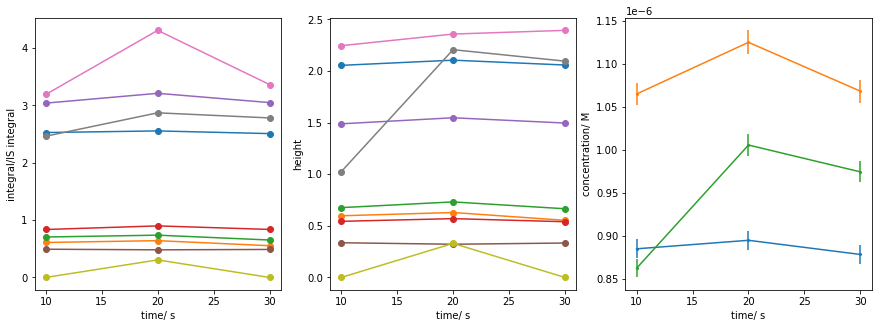

In [13]:
import matplotlib.pyplot as plt

conc_dict, err_dict, integral_dict, height_dict = series.series_traces_as_dict()

fig, ax = plt.subplots(ncols = 3, figsize = (15,5))

for i in integral_dict:
    ax[0].plot(series.series_values, integral_dict[i], '-o')
    
for i in height_dict:
    ax[1].plot(series.series_values, height_dict[i], '-o')
    
for c in conc_dict:
    ax[2].errorbar(series.series_values, conc_dict[c], 
                   yerr = err_dict[c], marker = 'o', 
                   markersize = 2)
  
for a in ax:
    a.set_xlabel(series.series_unit)
    
ax[0].set_ylabel('integral/IS integral')    
ax[1].set_ylabel('height')
ax[2].set_ylabel('concentration/ M')

The results of calculating concentrations can then be output using a similar process as for the integral series. If peaks have ben asssigned, the assignments will be incorporated into the integral series file, too.

In [14]:
series.write_data_reports(f'{data_report_directory}/{series.name}', analysis) # create arrays for output

...and that's the end of Part 2.